##### NSL-KDD Training using Multi Layer Perceptron

In [42]:
#Importing essential libraries
from sklearn.datasets import fetch_openml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os 
import cv2
import random 
import math

from datetime import datetime

from sklearn import metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow import keras

In [43]:
#importing the training data csv
intrusion_train = pd.read_csv('KDDTrain+.csv')

In [44]:
mapping = {'ipsweep': 'Probe','satan': 'Probe','nmap': 'Probe','portsweep': 'Probe','saint': 'Probe','mscan': 'Probe',
        'teardrop': 'DoS','pod': 'DoS','land': 'DoS','back': 'DoS','neptune': 'DoS','smurf': 'DoS','mailbomb': 'DoS',
        'udpstorm': 'DoS','apache2': 'DoS','processtable': 'DoS',
        'perl': 'U2R','loadmodule': 'U2R','rootkit': 'U2R','buffer_overflow': 'U2R','xterm': 'U2R','ps': 'U2R',
        'sqlattack': 'U2R','httptunnel': 'U2R',
        'ftp_write': 'R2L','phf': 'R2L','guess_passwd': 'R2L','warezmaster': 'R2L','warezclient': 'R2L','imap': 'R2L',
        'spy': 'R2L','multihop': 'R2L','named': 'R2L','snmpguess': 'R2L','worm': 'R2L','snmpgetattack': 'R2L',
        'xsnoop': 'R2L','xlock': 'R2L','sendmail': 'R2L',
        'normal': 'Normal'
        }

intrusion_train['attack_class'] = intrusion_train['labels'].apply(lambda v: mapping[v])

In [45]:
intrusion_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [46]:
intrusion_train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
intrusion_train["attack_class"].unique()

array(['Normal', 'DoS', 'R2L', 'Probe', 'U2R'], dtype=object)

In [48]:
intrusion_train['class']= pd.Categorical(intrusion_train['attack_class'],['DoS', 'Normal', 'Probe', 'R2L', 'U2R'])
intrusion_train['class']= intrusion_train['class'].cat.codes
intrusion_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels,attack_class,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,Normal,1
1,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,Normal,1
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,DoS,0
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,Normal,1
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,Normal,1


In [49]:
intrusion_train['protocol_type']=pd.Categorical(intrusion_train['protocol_type'],['tcp', 'icmp', 'udp'])
intrusion_train['protocol_type']= intrusion_train['protocol_type'].cat.codes
intrusion_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels,attack_class,class
0,0,0,ftp_data,SF,491,0,0,0,0,0,...,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,Normal,1
1,0,2,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,Normal,1
2,0,0,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,DoS,0
3,0,0,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,Normal,1
4,0,0,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,Normal,1


In [50]:
intrusion_train['service'].unique()

array(['ftp_data', 'other', 'private', 'http', 'remote_job', 'name',
       'netbios_ns', 'eco_i', 'mtp', 'telnet', 'finger', 'domain_u',
       'supdup', 'uucp_path', 'Z39_50', 'smtp', 'csnet_ns', 'uucp',
       'netbios_dgm', 'urp_i', 'auth', 'domain', 'ftp', 'bgp', 'ldap',
       'ecr_i', 'gopher', 'vmnet', 'systat', 'http_443', 'efs', 'whois',
       'imap4', 'iso_tsap', 'echo', 'klogin', 'link', 'sunrpc', 'login',
       'kshell', 'sql_net', 'time', 'hostnames', 'exec', 'ntp_u',
       'discard', 'nntp', 'courier', 'ctf', 'ssh', 'daytime', 'shell',
       'netstat', 'pop_3', 'nnsp', 'IRC', 'pop_2', 'printer', 'tim_i',
       'pm_dump', 'red_i', 'netbios_ssn', 'rje', 'X11', 'urh_i',
       'http_8001', 'aol', 'http_2784', 'tftp_u', 'harvest'], dtype=object)

In [51]:
intrusion_train['service']=pd.Categorical(intrusion_train['service'],['private', 'ftp_data', 'eco_i', 'telnet', 'http', 'smtp', 'ftp',
       'ldap', 'pop_3', 'courier', 'discard', 'ecr_i', 'imap4',
       'domain_u', 'mtp', 'systat', 'iso_tsap', 'other', 'csnet_ns',
       'finger', 'uucp', 'whois', 'netbios_ns', 'link', 'Z39_50',
       'sunrpc', 'auth', 'netbios_dgm', 'uucp_path', 'vmnet', 'domain',
       'name', 'pop_2', 'http_443', 'urp_i', 'login', 'gopher', 'exec',
       'time', 'remote_job', 'ssh', 'kshell', 'sql_net', 'shell',
       'hostnames', 'echo', 'daytime', 'pm_dump', 'IRC', 'netstat', 'ctf',
       'nntp', 'netbios_ssn', 'tim_i', 'supdup', 'bgp', 'nnsp', 'rje',
       'printer', 'efs', 'X11', 'ntp_u', 'klogin', 'tftp_u'])
intrusion_train['service']= intrusion_train['service'].cat.codes
intrusion_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels,attack_class,class
0,0,0,1,SF,491,0,0,0,0,0,...,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,Normal,1
1,0,2,17,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,Normal,1
2,0,0,0,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,DoS,0
3,0,0,4,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,Normal,1
4,0,0,4,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,Normal,1


In [52]:
intrusion_train['flag']=pd.Categorical(intrusion_train['flag'],['REJ', 'SF', 'RSTO', 'S0', 'RSTR', 'SH', 'S3', 'S2', 'S1',
       'RSTOS0', 'OTH'])
intrusion_train['flag']= intrusion_train['flag'].cat.codes
intrusion_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels,attack_class,class
0,0,0,1,1,491,0,0,0,0,0,...,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,Normal,1
1,0,2,17,1,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,Normal,1
2,0,0,0,3,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,DoS,0
3,0,0,4,1,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,Normal,1
4,0,0,4,1,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,Normal,1


In [53]:
intrusion_train['labels']=pd.Categorical(intrusion_train['labels'],['neptune', 'normal', 'saint', 'mscan', 'guess_passwd', 'smurf',
       'apache2', 'satan', 'buffer_overflow', 'back', 'warezmaster',
       'snmpgetattack', 'processtable', 'pod', 'httptunnel', 'nmap', 'ps',
       'snmpguess', 'ipsweep', 'mailbomb', 'portsweep', 'multihop',
       'named', 'sendmail', 'loadmodule', 'xterm', 'worm', 'teardrop',
       'rootkit', 'xlock', 'perl', 'land', 'xsnoop', 'sqlattack',
       'ftp_write', 'imap', 'udpstorm', 'phf'])
intrusion_train['labels']= intrusion_train['labels'].cat.codes
intrusion_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels,attack_class,class
0,0,0,1,1,491,0,0,0,0,0,...,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1,Normal,1
1,0,2,17,1,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.00,0.00,1,Normal,1
2,0,0,0,3,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0,DoS,0
3,0,0,4,1,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1,Normal,1
4,0,0,4,1,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,Normal,1


In [54]:
#Spliting the training data into input and labels
X_train = intrusion_train[['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate','labels']].values

y_train=intrusion_train[['class']].values

In [55]:
digit_train, counts_train = np.unique(y_train, return_counts = True)

distribution_train = dict(zip(digit_train, counts_train))
print(distribution_train)

{0: 45927, 1: 67343, 2: 11656, 3: 995, 4: 52}


There is an imbalance in the data proportion contributed from each class 

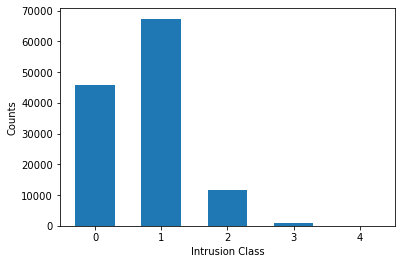

In [56]:
plt.bar(list(distribution_train.keys()),distribution_train.values(),width =0.6)
plt.xlabel('Intrusion Class')
plt.ylabel('Counts')
plt.show()

In [57]:
#Spliting the training data into validation set (20%)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(94479, 42) (31494, 42)
(94479, 1) (31494, 1)


In [58]:
import tensorflow as tf
from tensorflow import keras
print("Tensorflow Version:", tf.__version__)
print("Keras Version:", keras.__version__)


Tensorflow Version: 2.3.1
Keras Version: 2.4.0


In [59]:
#Adaptive Learning Rate
from tensorflow.keras.callbacks import LearningRateScheduler
def step_decay(epoch):
   initial_lrate = 0.1 #Setting the initial learning rate to 0.1 
   drop = 0.5
   epochs_drop = 10.0  #Drops the learning rate to half after every 10 epochs
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate
lrate = LearningRateScheduler(step_decay)

In [60]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

model = keras. models.Sequential()
model.add(keras.layers.Dense(21, activation ="sigmoid"))
#model.add(keras.layers.Dense(300, activation ="sigmoid"))
#model.add(keras.layers.Dense(300, activation ="sigmoid"))
#model.add(keras.layers.Dense(300, activation ="relu"))
#model.add(keras.layers.Dense(300, activation ="sigmoid"))
model.add(keras.layers.Dense(5, activation = "softmax"))

NAME ="IDS-Model-21-5/ALR/MLP"
tensorboard = TensorBoard(log_dir='logs_2/{}'.format(NAME))


#Defining callbacks with ALR, Early stopping , Tensorboard
early_stopping_monitor = EarlyStopping(patience=10)
#callbacks_list = [early_stopping_monitor,tensorboard,lrate]
callbacks_list = [lrate]

sgd = SGD(learning_rate=0.001)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

X_train = X_train.astype('float32')
y_train = y_train.astype('uint')
X_val = X_val.astype('float32')
y_val = y_val.astype('uint')

model.fit(X_train, y_train, batch_size=128, epochs=150, validation_data =(X_val,y_val) ,  callbacks =callbacks_list)

Epoch 1/150
739/739 [==============================] - 1s 1ms/step - loss: 0.2459 - accuracy: 0.9219 - val_loss: 0.1723 - val_accuracy: 0.9373
Epoch 2/150
739/739 [==============================] - 1s 1ms/step - loss: 0.1977 - accuracy: 0.9290 - val_loss: 0.2016 - val_accuracy: 0.9135
Epoch 3/150
739/739 [==============================] - 1s 1ms/step - loss: 0.2259 - accuracy: 0.9248 - val_loss: 0.2222 - val_accuracy: 0.9325
Epoch 4/150
739/739 [==============================] - 1s 1ms/step - loss: 0.1585 - accuracy: 0.9502 - val_loss: 0.1754 - val_accuracy: 0.9426
Epoch 5/150
739/739 [==============================] - 1s 1ms/step - loss: 0.1996 - accuracy: 0.9436 - val_loss: 0.2224 - val_accuracy: 0.9341
Epoch 6/150
739/739 [==============================] - 1s 1ms/step - loss: 0.2488 - accuracy: 0.9249 - val_loss: 0.2408 - val_accuracy: 0.9321
Epoch 7/150
739/739 [==============================] - 1s 1ms/step - loss: 0.2683 - accuracy: 0.9206 - val_loss: 0.2700 - val_accuracy: 0.9358

Epoch 58/150
739/739 [==============================] - 1s 1ms/step - loss: 0.0783 - accuracy: 0.9740 - val_loss: 0.0815 - val_accuracy: 0.9744
Epoch 59/150
739/739 [==============================] - 1s 1ms/step - loss: 0.0782 - accuracy: 0.9750 - val_loss: 0.0804 - val_accuracy: 0.9750
Epoch 60/150
739/739 [==============================] - 1s 1ms/step - loss: 0.0769 - accuracy: 0.9752 - val_loss: 0.0794 - val_accuracy: 0.9753
Epoch 61/150
739/739 [==============================] - 1s 1ms/step - loss: 0.0767 - accuracy: 0.9751 - val_loss: 0.0794 - val_accuracy: 0.9760
Epoch 62/150
739/739 [==============================] - 1s 1ms/step - loss: 0.0763 - accuracy: 0.9758 - val_loss: 0.0795 - val_accuracy: 0.9749
Epoch 63/150
739/739 [==============================] - 1s 1ms/step - loss: 0.0763 - accuracy: 0.9758 - val_loss: 0.0785 - val_accuracy: 0.9761
Epoch 64/150
739/739 [==============================] - 1s 1ms/step - loss: 0.0766 - accuracy: 0.9755 - val_loss: 0.0791 - val_accuracy:

Epoch 115/150
739/739 [==============================] - 1s 1ms/step - loss: 0.0718 - accuracy: 0.9780 - val_loss: 0.0761 - val_accuracy: 0.9776
Epoch 116/150
739/739 [==============================] - 1s 1ms/step - loss: 0.0718 - accuracy: 0.9780 - val_loss: 0.0761 - val_accuracy: 0.9777
Epoch 117/150
739/739 [==============================] - 1s 1ms/step - loss: 0.0720 - accuracy: 0.9781 - val_loss: 0.0763 - val_accuracy: 0.9777
Epoch 118/150
739/739 [==============================] - 1s 1ms/step - loss: 0.0719 - accuracy: 0.9781 - val_loss: 0.0760 - val_accuracy: 0.9777
Epoch 119/150
739/739 [==============================] - 1s 1ms/step - loss: 0.0720 - accuracy: 0.9780 - val_loss: 0.0760 - val_accuracy: 0.9777
Epoch 120/150
739/739 [==============================] - 1s 1ms/step - loss: 0.0720 - accuracy: 0.9781 - val_loss: 0.0760 - val_accuracy: 0.9777
Epoch 121/150
739/739 [==============================] - 1s 1ms/step - loss: 0.0719 - accuracy: 0.9781 - val_loss: 0.0760 - val_ac

In [61]:
#Importing the test data
intrusion_test = pd.read_csv('KDDTest+.csv') 

In [62]:
mapping = {'ipsweep': 'Probe','satan': 'Probe','nmap': 'Probe','portsweep': 'Probe','saint': 'Probe','mscan': 'Probe',
        'teardrop': 'DoS','pod': 'DoS','land': 'DoS','back': 'DoS','neptune': 'DoS','smurf': 'DoS','mailbomb': 'DoS',
        'udpstorm': 'DoS','apache2': 'DoS','processtable': 'DoS',
        'perl': 'U2R','loadmodule': 'U2R','rootkit': 'U2R','buffer_overflow': 'U2R','xterm': 'U2R','ps': 'U2R',
        'sqlattack': 'U2R','httptunnel': 'U2R',
        'ftp_write': 'R2L','phf': 'R2L','guess_passwd': 'R2L','warezmaster': 'R2L','warezclient': 'R2L','imap': 'R2L',
        'spy': 'R2L','multihop': 'R2L','named': 'R2L','snmpguess': 'R2L','worm': 'R2L','snmpgetattack': 'R2L',
        'xsnoop': 'R2L','xlock': 'R2L','sendmail': 'R2L',
        'normal': 'Normal'
        }

intrusion_test['attack_class'] = intrusion_test['labels'].apply(lambda v: mapping[v])

In [63]:
intrusion_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels,attack_class
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,DoS
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,DoS
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,Normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,Probe
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,Probe


In [64]:
intrusion_test["attack_class"].unique()

array(['DoS', 'Normal', 'Probe', 'R2L', 'U2R'], dtype=object)

In [66]:
#Handling the test categorical values
intrusion_test['class']= pd.Categorical(intrusion_test['attack_class'],['DoS', 'Normal', 'Probe', 'R2L', 'U2R'])
intrusion_test['class']= intrusion_test['class'].cat.codes

intrusion_test['protocol_type']=pd.Categorical(intrusion_test['protocol_type'],['tcp', 'icmp', 'udp'])
intrusion_test['protocol_type']= intrusion_test['protocol_type'].cat.codes


intrusion_test['service']=pd.Categorical(intrusion_test['service'],['private', 'ftp_data', 'eco_i', 'telnet', 'http', 'smtp', 'ftp',
       'ldap', 'pop_3', 'courier', 'discard', 'ecr_i', 'imap4',
       'domain_u', 'mtp', 'systat', 'iso_tsap', 'other', 'csnet_ns',
       'finger', 'uucp', 'whois', 'netbios_ns', 'link', 'Z39_50',
       'sunrpc', 'auth', 'netbios_dgm', 'uucp_path', 'vmnet', 'domain',
       'name', 'pop_2', 'http_443', 'urp_i', 'login', 'gopher', 'exec',
       'time', 'remote_job', 'ssh', 'kshell', 'sql_net', 'shell',
       'hostnames', 'echo', 'daytime', 'pm_dump', 'IRC', 'netstat', 'ctf',
       'nntp', 'netbios_ssn', 'tim_i', 'supdup', 'bgp', 'nnsp', 'rje',
       'printer', 'efs', 'X11', 'ntp_u', 'klogin', 'tftp_u'])
intrusion_test['service']= intrusion_test['service'].cat.codes


intrusion_test['flag']=pd.Categorical(intrusion_test['flag'],['REJ', 'SF', 'RSTO', 'S0', 'RSTR', 'SH', 'S3', 'S2', 'S1',
       'RSTOS0', 'OTH'])
intrusion_test['flag']= intrusion_test['flag'].cat.codes



intrusion_test['labels']=pd.Categorical(intrusion_test['labels'],['neptune', 'normal', 'saint', 'mscan', 'guess_passwd', 'smurf',
       'apache2', 'satan', 'buffer_overflow', 'back', 'warezmaster',
       'snmpgetattack', 'processtable', 'pod', 'httptunnel', 'nmap', 'ps',
       'snmpguess', 'ipsweep', 'mailbomb', 'portsweep', 'multihop',
       'named', 'sendmail', 'loadmodule', 'xterm', 'worm', 'teardrop',
       'rootkit', 'xlock', 'perl', 'land', 'xsnoop', 'sqlattack',
       'ftp_write', 'imap', 'udpstorm', 'phf'])
intrusion_test['labels']= intrusion_test['labels'].cat.codes
intrusion_test.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels,attack_class,class
0,0,0,0,0,0,0,0,0,0,0,...,0.06,0.00,0.00,0.0,0.0,1.00,1.00,0,DoS,0
1,0,0,0,0,0,0,0,0,0,0,...,0.06,0.00,0.00,0.0,0.0,1.00,1.00,0,DoS,0
2,2,0,1,1,12983,0,0,0,0,0,...,0.04,0.61,0.02,0.0,0.0,0.00,0.00,1,Normal,1
3,0,1,2,1,20,0,0,0,0,0,...,0.00,1.00,0.28,0.0,0.0,0.00,0.00,2,Probe,2
4,1,0,3,2,0,15,0,0,0,0,...,0.17,0.03,0.02,0.0,0.0,0.83,0.71,3,Probe,2


In [67]:
X_test = intrusion_test[['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate','labels']].values

y_test=intrusion_test[['class']].values

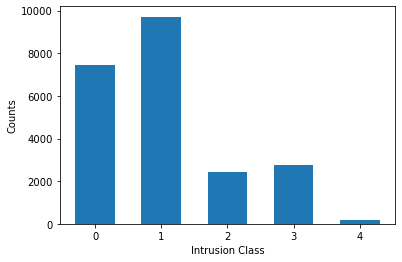

In [68]:
digit_test, counts_test = np.unique(y_test, return_counts = True)

distribution_test = dict(zip(digit_test, counts_test))
plt.bar(list(distribution_test.keys()),distribution_test.values(),width =0.6)
plt.xlabel('Intrusion Class')
plt.ylabel('Counts')
plt.show()

In [69]:
X_test = X_test.astype('float32')
y_test = y_test.astype('uint')


loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.698


In [70]:
from sklearn.metrics import classification_report, confusion_matrix

y_proba = model.predict(X_test) 
y_pred = model.predict_classes(X_test)
print('Confusion Matrix')
print(confusion_matrix(y_pred, y_test))
print('Classification Report')
print(classification_report(y_pred, y_test))

Confusion Matrix
[[5032  408  257   13   17]
 [1862 9167  782 2141   61]
 [ 502  119 1358  425   95]
 [  62   17   23  173   27]
 [   0    0    1    2    0]]
Classification Report
              precision    recall  f1-score   support

           0       0.67      0.88      0.76      5727
           1       0.94      0.65      0.77     14013
           2       0.56      0.54      0.55      2499
           3       0.06      0.57      0.11       302
           4       0.00      0.00      0.00         3

    accuracy                           0.70     22544
   macro avg       0.45      0.53      0.44     22544
weighted avg       0.82      0.70      0.74     22544

